Petite démo rapide pour montrer que notre modèle génère bien des images. 

Tout d'abord, veuillez choisir une seed et un chiffre (0 à 9) que vous voulez que le modèle génère.

In [30]:
import jax
from jax import numpy as jnp
from flax.training import checkpoints
from flax import nnx
import diffrax 
import unet
import os
import matplotlib.pyplot as plt
import numpy as np

seed = 832
mon_chiffre = 3

Maintenant, commençons par prendre des images bruit gaussien tout moche.

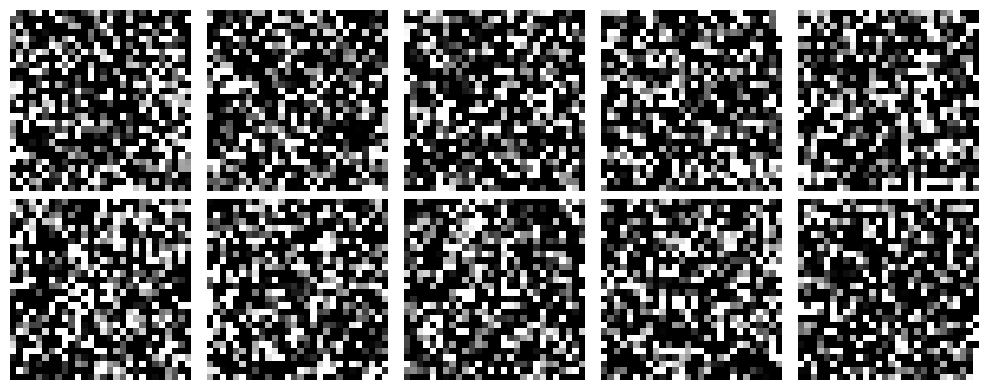

In [31]:
key = jax.random.PRNGKey(seed)

x0 = jax.random.normal(key, (10, 28, 28, 1))

def show(images, rows, cols):
    fig, axes = plt.subplots(rows, cols, figsize=(cols*2, rows*2))

    idx = 0
    for r in range(rows):
        for c in range(cols):
            ax = axes[r, c]
            ax.axis("off")
            image = images[idx]
            image = jnp.squeeze(image)
            ax.imshow(np.asarray(image), cmap="gray", vmin=0.0, vmax=1.0)
            idx += 1

    plt.tight_layout()
    plt.show()
show(x0, 2, 5)

Laissons le modèle faire sa magie : transformons ces bruits en images du chiffre choisi. Vous verrez sûrement que ce n'est pas terrible...

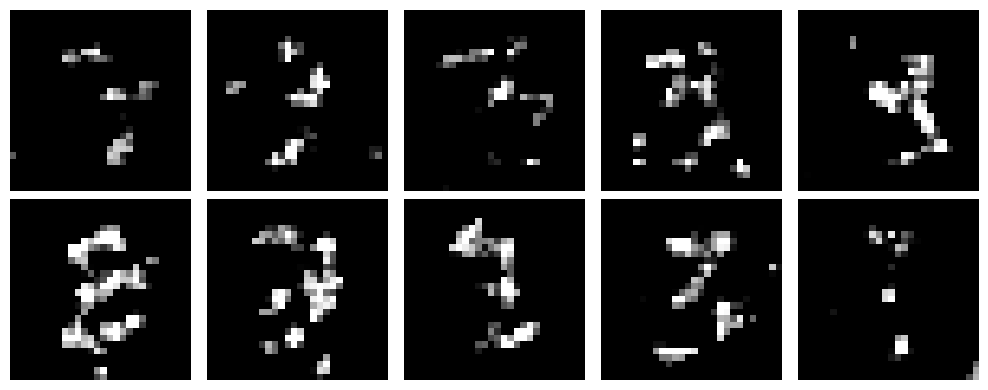

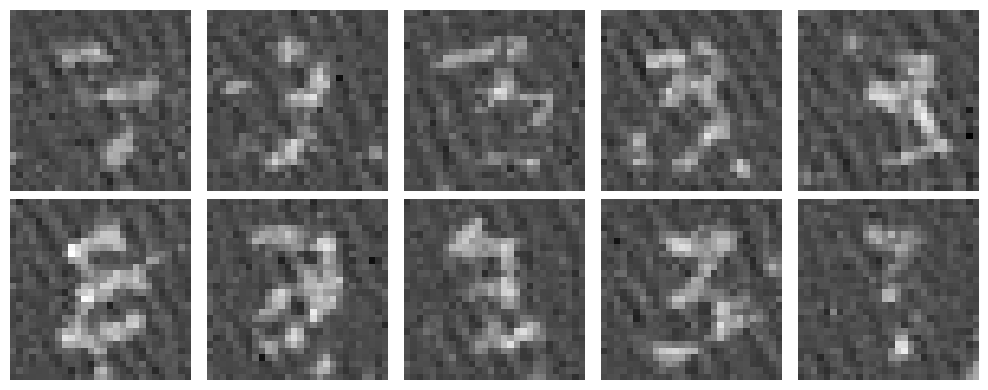

In [32]:
#On commence par restaurer le modèle sauvegardé par train.py
model_dir =  os.path.abspath("./saved_models/V4")
restored_state = checkpoints.restore_checkpoint(model_dir, target=None)

abstract_model = nnx.eval_shape(lambda: unet.UNet(in_channels=1, time_dim=40, label_dim=40, rngs=nnx.Rngs(0)))
abstract_params, abstract_state = nnx.split(abstract_model)
nnx.replace_by_pure_dict(abstract_state, restored_state)
model = nnx.merge(abstract_params, restored_state)

#On dit ce qu'on veut générer comme chiffre, donc on génère un tableau du bon chiffre
y = jnp.full((10,), mon_chiffre, dtype=jnp.int32)


#Puis on prend de quoi résoudre l'ODE (avec la méthode de Euler) qu'on déduit par le modèle entrainé
def vector_field(t, x, _):
    """
        On veut résoudre dx/dt = v_t(x) avec v_t(x) donné par le modèle entrainé avec t et x en entrée.
    """
    return model(x, t, y)  

def sample(x0, steps):
    #On résout l'ODE (décrite dans vector_field) de t=0 à t=1 avec la méthode d'Euler
    term = diffrax.ODETerm(vector_field)
    solver = diffrax.Euler()
    dt = 1.0 / steps
    solution_magique = diffrax.diffeqsolve(term, solver, t0=0.0, t1=1.0, dt0=dt, y0=x0, saveat=diffrax.SaveAt(t1=True), stepsize_controller=diffrax.ConstantStepSize())
    samples = jnp.squeeze(solution_magique.ys, axis=0)
    normalized = (samples - jnp.min(samples)) / (jnp.max(samples) - jnp.min(samples))
    return samples, normalized

samples, normalized = sample(x0, 500)

show(samples, 2, 5)
show(normalized, 2, 5)

Et voilà ! L'image donnée par le README et qui a le mérite de montrer un de chaque chiffre est générée par le code suivant.

Je vous laisse le tourner pour avoir la même image mais à partir d'une seed différente (celle du README est seed=0).

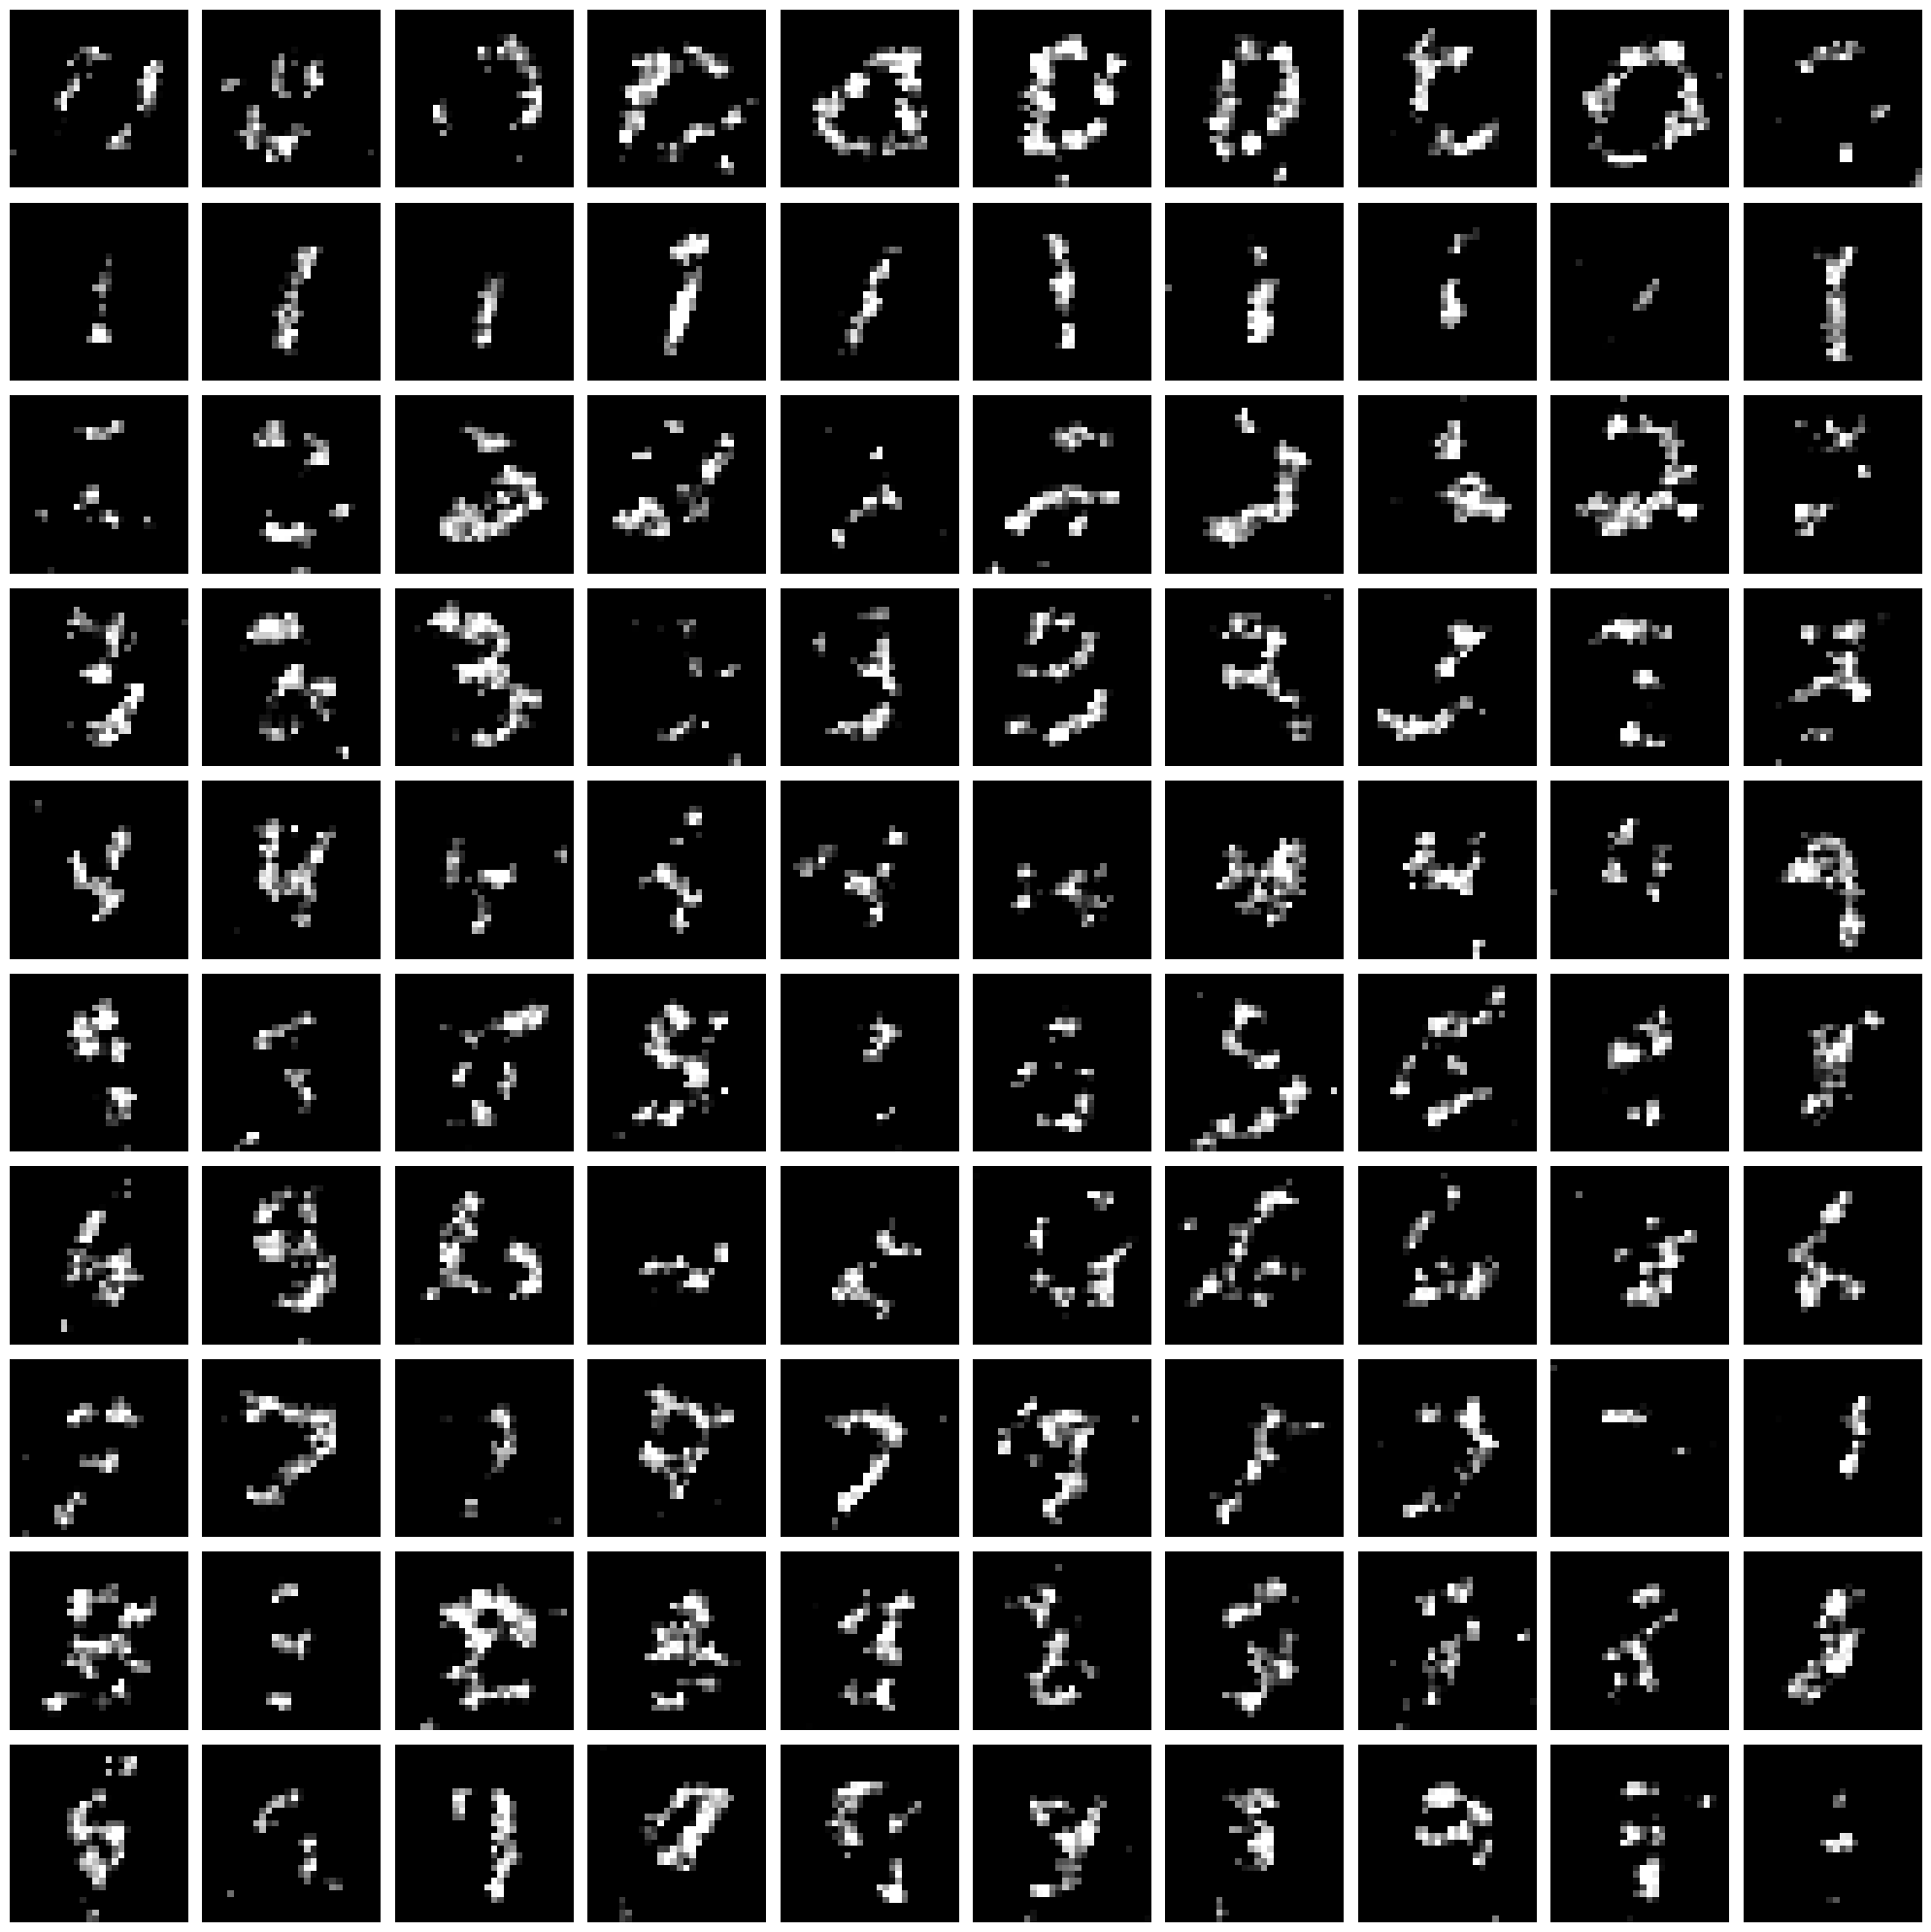

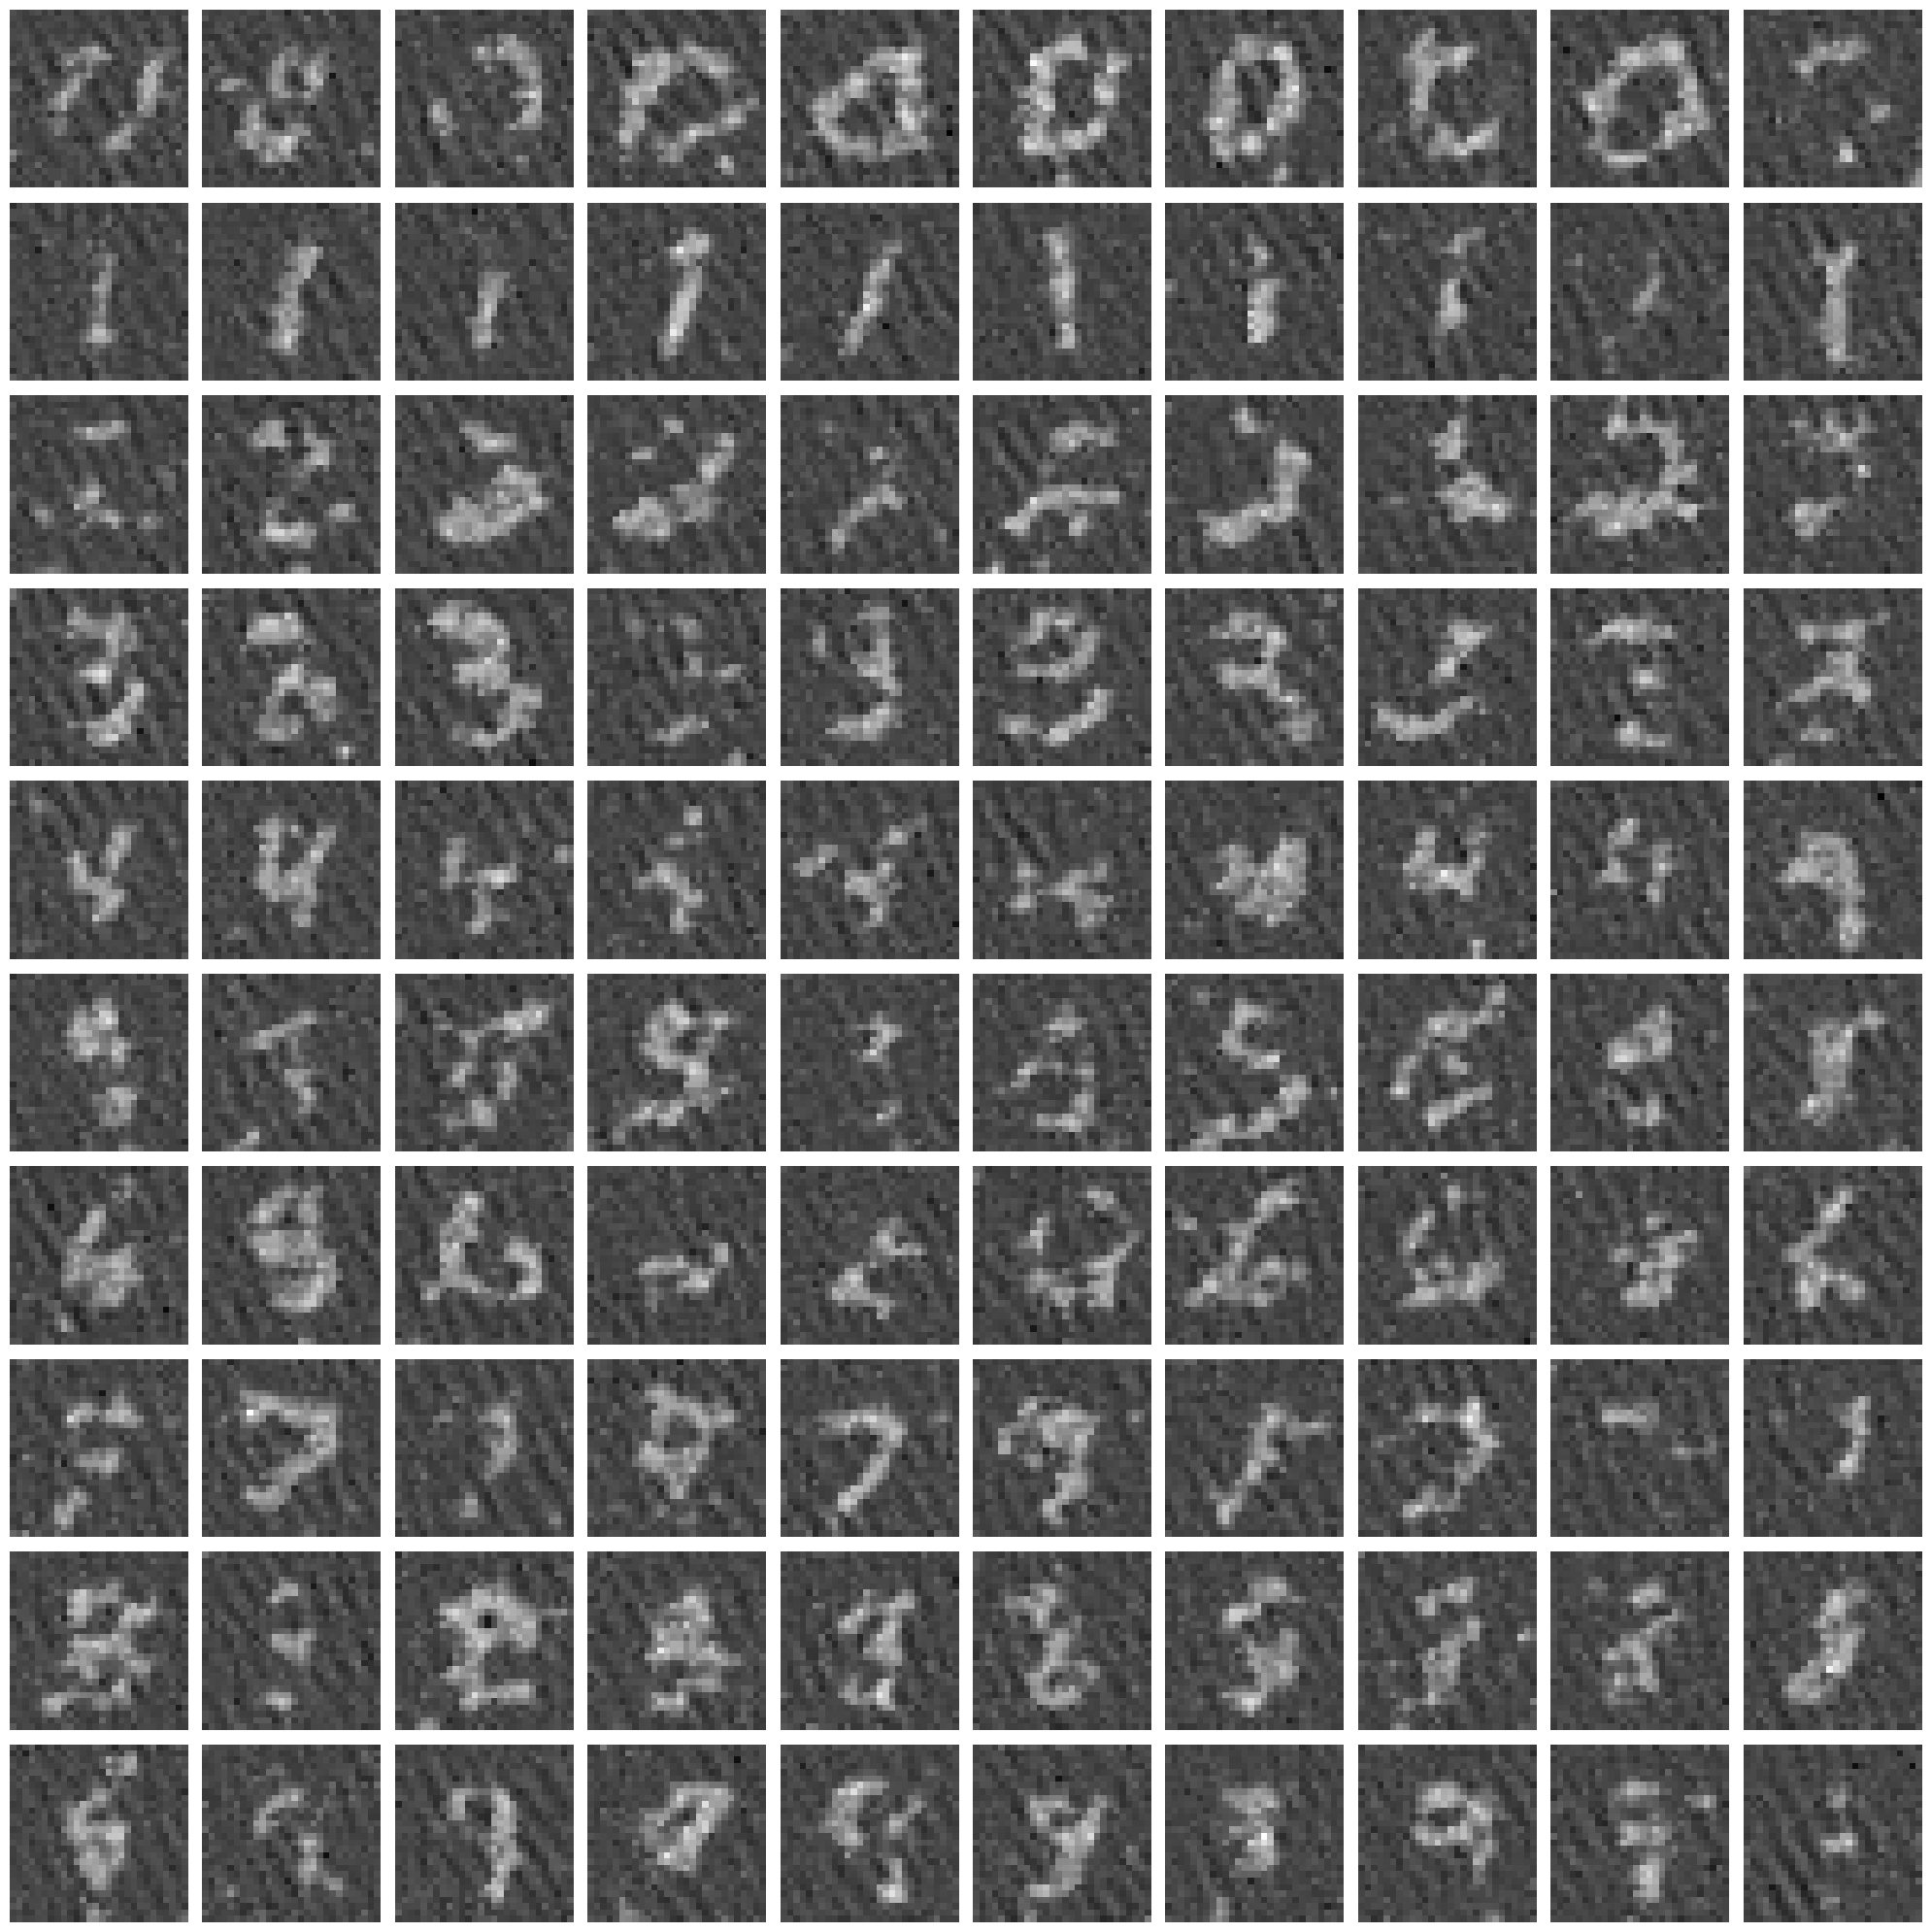

In [33]:
#On commence par restaurer le modèle sauvegardé par train.py
model_dir =  os.path.abspath("./saved_models/V4")
restored_state = checkpoints.restore_checkpoint(model_dir, target=None)

abstract_model = nnx.eval_shape(lambda: unet.UNet(in_channels=1, time_dim=40, label_dim=40, rngs=nnx.Rngs(0)))
abstract_params, abstract_state = nnx.split(abstract_model)
nnx.replace_by_pure_dict(abstract_state, restored_state)
model = nnx.merge(abstract_params, restored_state)

#On dit ce qu'on veut générer comme chiffre, donc on génère un tableau du bon chiffre
y = jnp.repeat(jnp.arange(10, dtype=jnp.int32), 10)

#Puis on prend de quoi résoudre l'ODE (avec la méthode de Euler) qu'on déduit par le modèle entrainé
def vector_field(t, x, _):
    """
        On veut résoudre dx/dt = v_t(x) avec v_t(x) donné par le modèle entrainé avec t et x en entrée.
    """
    return model(x, t, y)  

def sample(num_samples, steps):
    x0 = jax.random.normal(key, (num_samples, 28, 28, 1))
    #On résout l'ODE (décrite dans vector_field) de t=0 à t=1 avec la méthode d'Euler
    term = diffrax.ODETerm(vector_field)
    solver = diffrax.Euler()
    dt = 1.0 / steps
    solution_magique = diffrax.diffeqsolve(term, solver, t0=0.0, t1=1.0, dt0=dt, y0=x0, saveat=diffrax.SaveAt(t1=True), stepsize_controller=diffrax.ConstantStepSize())
    samples = jnp.squeeze(solution_magique.ys, axis=0)
    normalized = (samples - jnp.min(samples)) / (jnp.max(samples) - jnp.min(samples))
    return samples, normalized

samples, normalized = sample(100, 500)

show(samples, 10, 10)
show(normalized, 10, 10)